# Talk Page Contributor Analysis

[Task](https://phabricator.wikimedia.org/T233261) [Codebase](https://github.com/wikimedia-research/2019-10-talk-pages-baseline-metrics)

# Contents

1. [Purpose](#Purpose)
2. [Definitions](#Definitions)
3. [Junior Talk Page Contributor Analysis](#Junior-Talk-Page-Contributor-Analysis)
4. [Overall Talk Page Contributor Analysis](#Overall-Talk-Page-Contributor-Analysis)



# Purpose

We are curious to know the number of distinct junior contributors contributing to talk pages and how that number has changed over time.

This information will be helpful to 
(1) establish a baseline for one of the key results for the project: Increasing the number of junior contributors participating in conversations on talk pages by 5%
(2) inform target wiki selection


This report includes:
* Junior Contributor Analyis: Year-over-year variation in the monthly distinct number of "junior contributors" who have contributed to a talk page from August 2014 - August 2019
* Overall Talk Page Contributors by Wiki and Experience Level: A breakdown of number of monthly distinct talk page contributors by experience level and by wikipedia to help inform selection of target wikis for OWC project. 





# Definitions

See full list defined in [T234046](https://phabricator.wikimedia.org/T234046)

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales)
})

# Collect Data

In [111]:
# Talk page editors who have edited Wikipedia by wiki and experience level
query <- 
"SELECT
  date,
  wiki,
  user_id,
  user_name,
  count(*) as talk_edits, 
  user_is_bot,
  user_edit_count_bucket
FROM
  ( 
  SELECT
    trunc(event_timestamp, 'MONTH') as date,
    wiki_db as wiki,
    event_user_id as user_id,
    event_user_text as user_name,
    page_namespace_historical,
    ARRAY_CONTAINS(event_user_groups_historical, 'bot') as user_is_bot,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count_bucket
FROM wmf.mediawiki_history mwh
inner join canonical_data.wikis_backup_20191030
on
    wiki_db = database_code and
    database_group ==  'wikipedia'
WHERE
    event_timestamp >= '2014-09-01' and 
    event_timestamp < '2019-11-01' and 
    event_entity = 'revision' and
    event_type = 'create' and
    snapshot = '2019-10' and 
    page_namespace_historical % 2 == 1   -- all talk pages have odd numbered page_namespace 

) as info
GROUP BY
    date,
    wiki,
    user_id,
    user_name,
    user_is_bot,
    user_edit_count_bucket"


In [112]:
talk_contributor_edits <- wmf::query_hive(query)

In [113]:
talk_contributor_edits$date <- as.Date(talk_contributor_edits$date, format = "%Y-%m-%d")

# Junior Talk Page Contributor Analysis

## Overall # of Monthly Unique Junior Contributors 

In [114]:
junior_contributors_monthly <- talk_contributor_edits %>%
  filter(user_is_bot == 'false',
         user_id != 'NULL',
        user_edit_count_bucket == 'under 100') %>%
  group_by(date) %>%
  summarise(junior_contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))

In [115]:
tail(junior_contributors_monthly)

date,junior_contributors,talk_edits_total
<date>,<int>,<int>
2019-05-01,22867,63246
2019-06-01,20000,56076
2019-07-01,20985,60088
2019-08-01,22303,61922
2019-09-01,25439,70290
2019-10-01,25588,72573


In [116]:
average_contributors_monthly <- junior_contributors_monthly %>%
   filter(date >= '2018-10-01')  %>% #look at last 12 months
   summarise(average_monthly_contributors = mean(junior_contributors))

average_contributors_monthly

average_monthly_contributors
<dbl>
24400.23


From September 1, 2018 through September 30, 2019, there are an average of 2.4K unique junior contributors per month that contribute to talk pages on wikipedias.

In [117]:
junior_contributors_monthly_yoy <- junior_contributors_monthly %>%
   arrange(date) %>%
   mutate(yoy_percent = (junior_contributors/lag(junior_contributors,12) -1) *100) %>%
   arrange(desc(date))

head(junior_contributors_monthly_yoy, 10)

date,junior_contributors,talk_edits_total,yoy_percent
<date>,<int>,<int>,<dbl>
2019-10-01,25588,72573,-6.0335647
2019-09-01,25439,70290,3.6760810
2019-08-01,22303,61922,-1.7099290
2019-07-01,20985,60088,-0.4081439
2019-06-01,20000,56076,-5.4507635
2019-05-01,22867,63246,-0.9314617
2019-04-01,25043,69557,-5.8108921
2019-03-01,26527,74329,-5.7354039
2019-02-01,25917,73736,0.6016614


Saving 6.67 x 6.67 in image


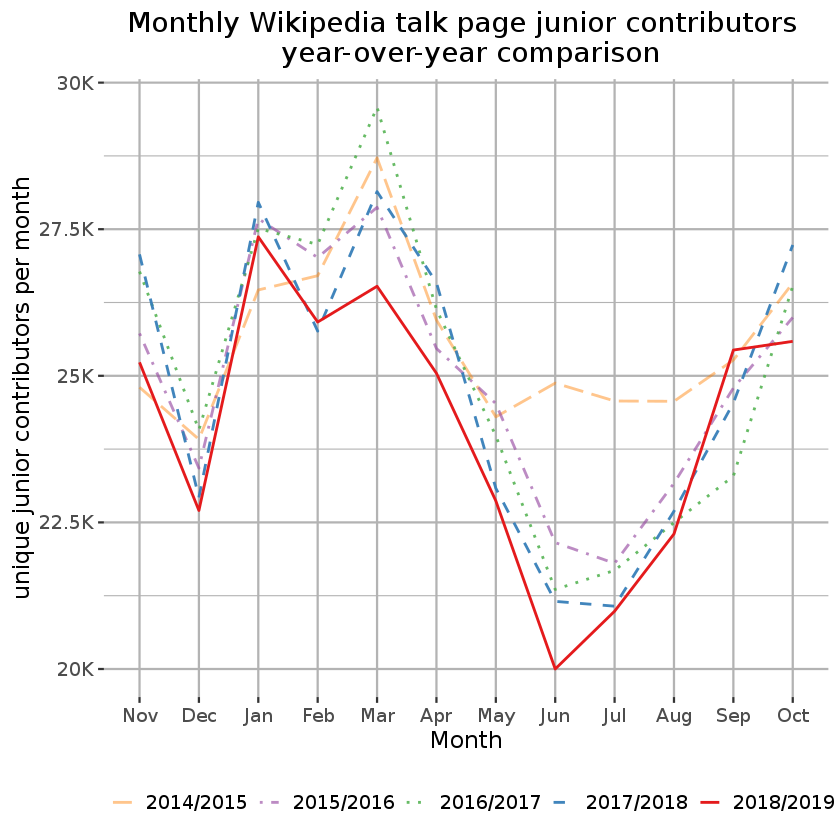

In [125]:
# Plot YoY Changes for Junior Contributors

junior_contributor_yoy_plot <- junior_contributors_monthly_yoy %>%
 filter (date >= '2014-11-01') %>% #Remove extra months to do equal comparison between year
 mutate(year = case_when(date >= '2014-11-01' & date < '2015-11-01' ~ '2014/2015',
                         date >= '2015-11-01' & date < '2016-11-01' ~ '2015/2016',
                         date >= '2016-11-01' & date < '2017-11-01' ~ '2016/2017',
                         date >= '2017-11-01' & date < '2018-11-01' ~ '2017/2018',
                         date >= '2018-11-01' & date < '2019-11-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         Month = months(as.Date(date), abbreviate=TRUE))


junior_contributor_yoy_plot$MonthN = factor(junior_contributor_yoy_plot$MonthN, levels=c( "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09", "10"))

junior_contributor_yoy_plot$year = factor(junior_contributor_yoy_plot$year, levels = c('2014/2015','2015/2016','2016/2017','2017/2018','2018/2019'))


p <- ggplot(junior_contributor_yoy_plot, aes(x=MonthN, y = junior_contributors, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 0.8) +
  scale_y_continuous("unique junior contributors per month", labels = polloi::compress) +
  scale_x_discrete(breaks = junior_contributor_yoy_plot$MonthN, labels = junior_contributor_yoy_plot$Month )+
  labs(title = "Monthly Wikipedia talk page junior contributors \n year-over-year comparison") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), direction= -1) +
        scale_linetype_manual(breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), values=c(5,4,3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm"))


ggsave(filename="junior_contributor_yoy_plot.png", plot = p, path = 'Figures')  
p

This data follows similar seasonal trends we see with overall pageview data. The number of junior contributors contributing to talk pages decreases around the holidays/Christmas and from May to June.

There's primarily been a decline in the number of junior contributors with some year over year increase occuring during the year. Notably there was a year over year increase from September to October 2019, with the number of monthly distinct contributors surpassing all the past previous year.

**Talk Page Junior Contributors YoY Comparison (August 2018 and August 2019) **

 |                                   | August 2018 | August 2019 | Percent Change |
 |-----------------------------------|-------------|-------------|----------------|
 | distinct # of junior contributors          | 30318       | 29272       | -3.45%         |
 | total # of edits by junior contributors | 70290       | 70760       |  0.67%         |

# Overall Talk Page Contributor Analysis

## Overall Talk Page Contributors By Experience Level

In [119]:
talk_contributors_monthly_byeditcount <- talk_contributor_edits  %>%
  filter(user_is_bot == 'false',
        user_edit_count_bucket != 'undefined',
          user_id != 'NULL') %>%  
  group_by(date, user_edit_count_bucket) %>%
  summarise(contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))

head(talk_contributors_monthly_byeditcount)

       


date,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<int>,<int>
2014-09-01,100-499,6340,38422
2014-09-01,500+,20297,900345
2014-09-01,under 100,23596,71256
2014-10-01,100-499,6420,40499
2014-10-01,500+,20545,918895
2014-10-01,under 100,25274,73166


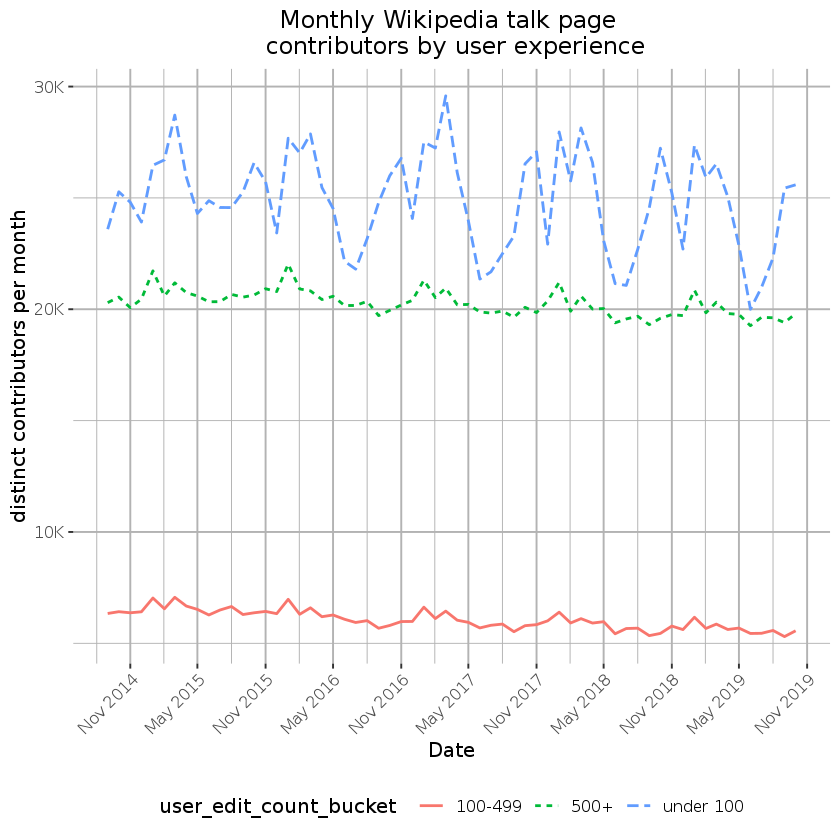

In [120]:
#Plot timeseries of unique contributors by experience level

p <- ggplot(talk_contributors_monthly_byeditcount, aes(x= date, y = contributors, color = user_edit_count_bucket, linetype = user_edit_count_bucket)) +    
  geom_line(size =0.8) +
  scale_y_continuous("distinct contributors per month", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "6 months") +
  labs(title = "Monthly Wikipedia talk page \n contributors by user experience") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="contributors_byuserexperience.png", plot = p, path = 'Figures')  
p

There are greater fluctuations with junior contributors with under 100 edits; however, there are also more unique contributors in this experience level group than the 500+ or the under 100 edits experience level groups.

In [36]:
head(talk_contributors_monthly_byeditcount)

date,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<int>,<int>
2014-09-01,100-499,6340,38422
2014-09-01,500+,20297,900345
2014-09-01,under 100,23596,71256
2014-10-01,100-499,6420,40499
2014-10-01,500+,20545,918895
2014-10-01,under 100,25273,73165


In [78]:
#Calculate YOY changes for each user edit count bucket

talk_contributors_monthly_under100_yoy <- talk_contributor_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == 'under 100',
          user_id != 'NULL') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))


talk_contributors_monthly_100_yoy <- talk_contributor_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == '100-499',
          user_id != 'NULL') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))


talk_contributors_monthly_500_yoy <- talk_contributor_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == '500+',
          user_id != 'NULL') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))

In [79]:
# yoy table for September 2019
edit_count <- c('under 100', '100+', '500+')
talk_contributors_monthy_byeditcount_yoy <- rbind(talk_contributors_monthly_under100_yoy [1,], talk_contributors_monthly_100_yoy [1,], talk_contributors_monthly_500_yoy [1,])

talk_contributors_monthy_byeditcount_yoy$edit_count= edit_count

talk_contributors_monthy_byeditcount_yoy 

date,contributors,yoy_percent,edit_count
<date>,<int>,<dbl>,<chr>
2019-09-01,25438,3.6762308,under 100
2019-09-01,5302,-0.8044902,100+
2019-09-01,19401,0.4816656,500+


Saving 6.67 x 6.67 in image


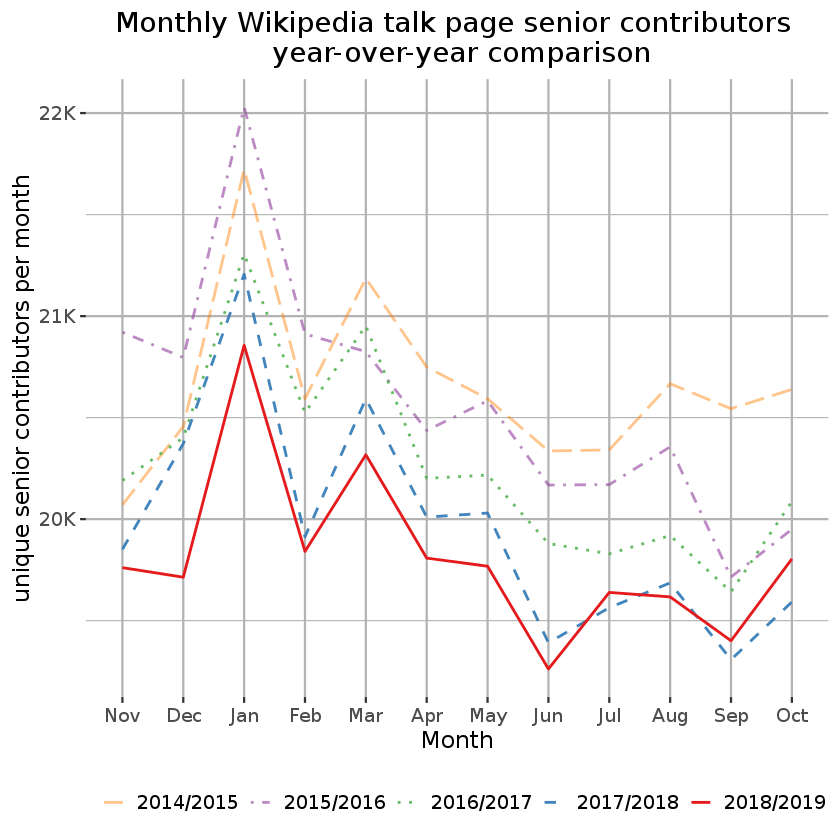

In [127]:
# Create YoY plot for senior talk page contributors

senior_talk_contributor_yoy_plot <- talk_contributors_monthly_500_yoy %>%
 filter(date >= '2014-11-01') %>% #Remove extra month to do equal comparison between year
 mutate(year = case_when(date >= '2014-11-01' & date < '2015-11-01' ~ '2014/2015',
                         date >= '2015-11-01' & date < '2016-11-01' ~ '2015/2016',
                         date >= '2016-11-01' & date < '2017-11-01' ~ '2016/2017',
                         date >= '2017-11-01' & date < '2018-11-01' ~ '2017/2018',
                         date >= '2018-11-01' & date < '2019-11-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         Month = months(as.Date(date), abbreviate=TRUE))


senior_talk_contributor_yoy_plot$MonthN = factor(senior_talk_contributor_yoy_plot$MonthN, levels=c( "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09", "10"))

senior_talk_contributor_yoy_plot$year = factor(senior_talk_contributor_yoy_plot$year, levels = c('2014/2015','2015/2016','2016/2017','2017/2018','2018/2019'))


p <- ggplot(senior_talk_contributor_yoy_plot, aes(x=MonthN, y = contributors, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 0.8) +
  scale_y_continuous("unique senior contributors per month", labels = polloi::compress) +
  scale_x_discrete(breaks = senior_talk_contributor_yoy_plot$MonthN, labels = senior_talk_contributor_yoy_plot$Month )+
  labs(title = "Monthly Wikipedia talk page senior contributors \n year-over-year comparison") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), direction=-1) +
        scale_linetype_manual(breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), values=c(5,4,3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm")) 


ggsave(filename="senior_contributor_yoy_plot.png", plot = p, path = 'Figures', units = "in")  
p

There's primiarly been a year over year decline in the number of monthly distinct senior contributors participating on talk pages; however, there were some recent year over year increase in July and September 2019.

## Overall Talk Page Contributors By Wiki

Review the number of unique talk page contributors by wiki that participate on talk pages over the past 12 months.

In [ ]:

talk_contributors_monthly_bywiki <- talk_contributor_edits %>%
    filter(user_is_bot == 'false',
           user_id != 'NULL', 
           date >= '2018-10-01') %>%  #look at last 12 months
    group_by(date, wiki) %>%
    summarise(talk_contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))
    

head(talk_contributors_monthly_bywiki)

In [131]:
# Top 10 wikis by average number of contributors participating on talk pages per month

talk_contributors_average_bywiki <- talk_contributors_monthly_bywiki %>%
    group_by(wiki)  %>%
    summarise(avg_talk_contributors = mean(talk_contributors)) %>%
    arrange(desc(avg_talk_contributors))

head(talk_contributors_average_bywiki, 10)

wiki,avg_talk_contributors
<chr>,<dbl>
enwiki,23957.8462
dewiki,4532.6923
frwiki,3099.8462
eswiki,2025.1538
ruwiki,1988.6923
itwiki,1382.2308
jawiki,1170.0769
fawiki,1126.8462
zhwiki,970.5385


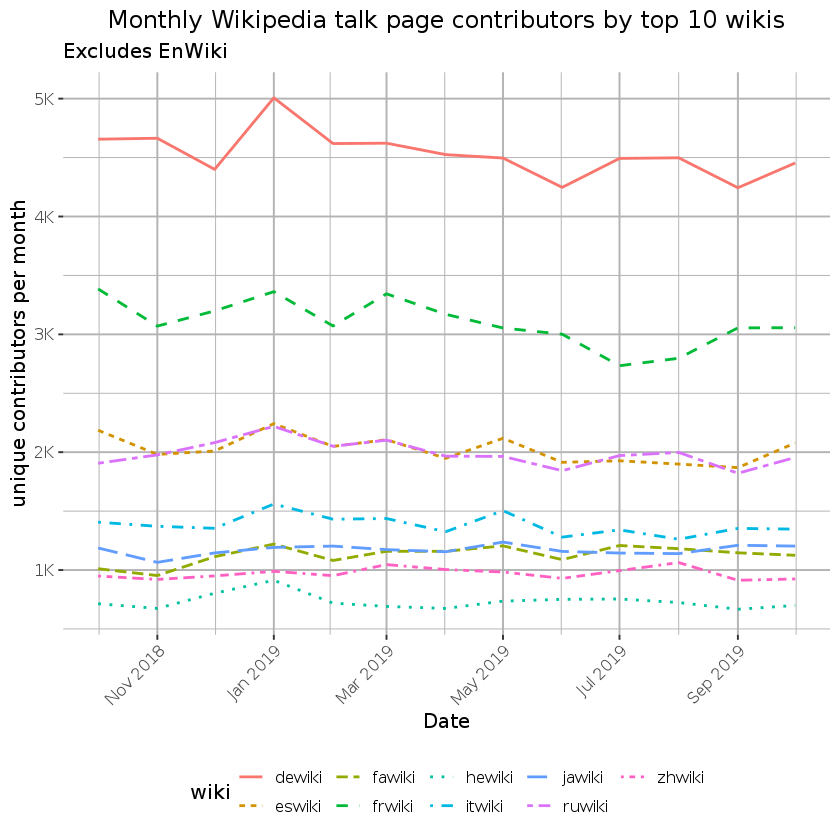

In [132]:
# Plot time series of the top 10 wikis overall. Excluding enwiki for visualization purposes.

p <- talk_contributors_monthly_bywiki %>%
    filter(wiki %in% c('dewiki', 'frwiki', 'eswiki', 'ruwiki', 'itwiki', 'jawiki', 'fawiki', 'hewiki', 'zhwiki')) %>%
    ggplot( aes(x= date, y = talk_contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months") +
        labs(title = "Monthly Wikipedia talk page contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="contributors_monthly_bywiki.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p


### Per Wiki Breakdown by Experience Level

In [ ]:
talk_contributors_monthly_bywiki_byeditcount <- talk_contributor_edits %>%
    filter(user_is_bot == 'false',
           date >= '2018-10-01', #look at last 12 months
           user_edit_count_bucket != 'undefined' ,
           user_id != 'NULL'
       ) %>% 
    group_by(date, wiki, user_edit_count_bucket) %>%
    summarise(talk_contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))
    

head(talk_contributors_monthly_bywiki_byeditcount)

In [137]:
# Junior Contributors: Top 10 by average number of contributors per month by experience

talk_contributors_average_bywiki_junior <- talk_contributors_monthly_bywiki_byeditcount %>%
    filter(user_edit_count_bucket == 'under 100') %>%
    group_by(wiki)  %>%
    summarise(avg_talk_junior_contributors = mean(talk_contributors)) %>%
    arrange(desc(avg_talk_junior_contributors))

head(talk_contributors_average_bywiki_junior, 10)

wiki,avg_talk_junior_contributors
<chr>,<dbl>
enwiki,13445.0769
dewiki,1367.1538
frwiki,1336.0769
eswiki,1105.0000
fawiki,826.4615
ruwiki,756.1538
arwiki,612.0000
itwiki,554.6154
ptwiki,455.8462


Saving 6.67 x 6.67 in image


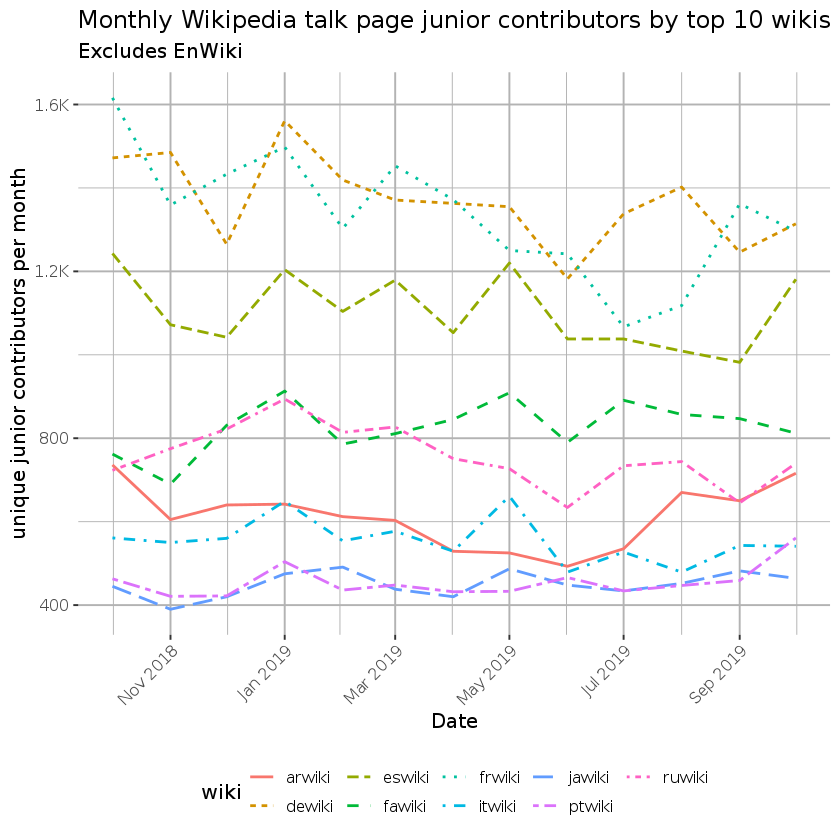

In [142]:
# Plot time series of the top 10 wikis - junior contributors

p <- talk_contributors_monthly_bywiki_byeditcount  %>%
    filter(user_edit_count_bucket == 'under 100',
           wiki %in% c('dewiki', 'frwiki', 'eswiki', 'fawiki', 'ruwiki', 'arwiki', 'itwiki', 'ptwiki', 'jawiki')) %>%
    ggplot( aes(x= date, y = talk_contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique junior contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months") +
        labs(title = "Monthly Wikipedia talk page junior contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="junior_contributors_monthly_bywiki.png", plot = p, path = 'Figures')
p

In [139]:
# Senior Contributors: Top 10 by average number of contributors per month by experience

talk_contributors_average_bywiki_senior <- talk_contributors_monthly_bywiki_byeditcount %>%
    filter(user_edit_count_bucket == '500+') %>%
    group_by(wiki)  %>%
    summarise(avg_talk_junior_contributors = mean(talk_contributors)) %>%
    arrange(desc(avg_talk_junior_contributors))

head(talk_contributors_average_bywiki_senior , 10)

wiki,avg_talk_junior_contributors
<chr>,<dbl>
enwiki,8038.6154
dewiki,2640.2308
frwiki,1452.3077
ruwiki,1023.8462
eswiki,740.8462
itwiki,686.8462
jawiki,576.8462
zhwiki,536.0000
plwiki,444.9231


Saving 6.67 x 6.67 in image


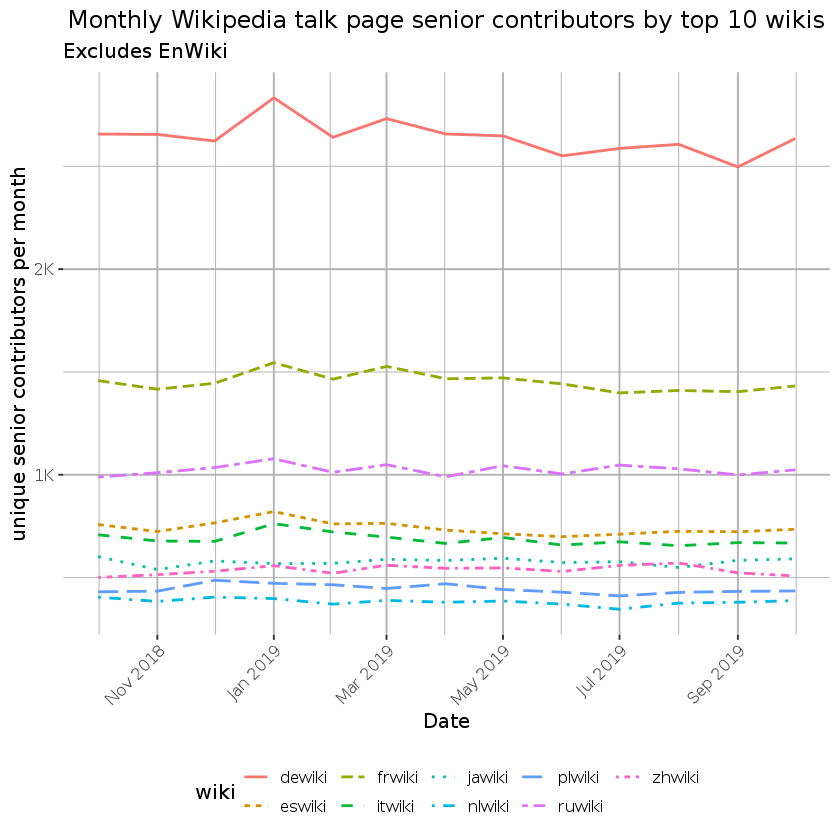

In [140]:
# Plot time series of the top 10 wikis - senior contributors

p <- talk_contributors_monthly_bywiki_byeditcount  %>%
    filter(user_edit_count_bucket == '500+',
           wiki %in% c('dewiki', 'frwiki','ruwiki', 'eswiki', 'itwiki', 'jawiki', 'zhwiki', 'plwiki', 'nlwiki')) %>%
    ggplot( aes(x= date, y = talk_contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique senior contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months") +
        labs(title = "Monthly Wikipedia talk page senior contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="senior_contributors_monthly_bywiki.png", plot = p, path = 'Figures')
p

### Stacked bar chart showing proportion by user edit count

Saving 6.67 x 6.67 in image


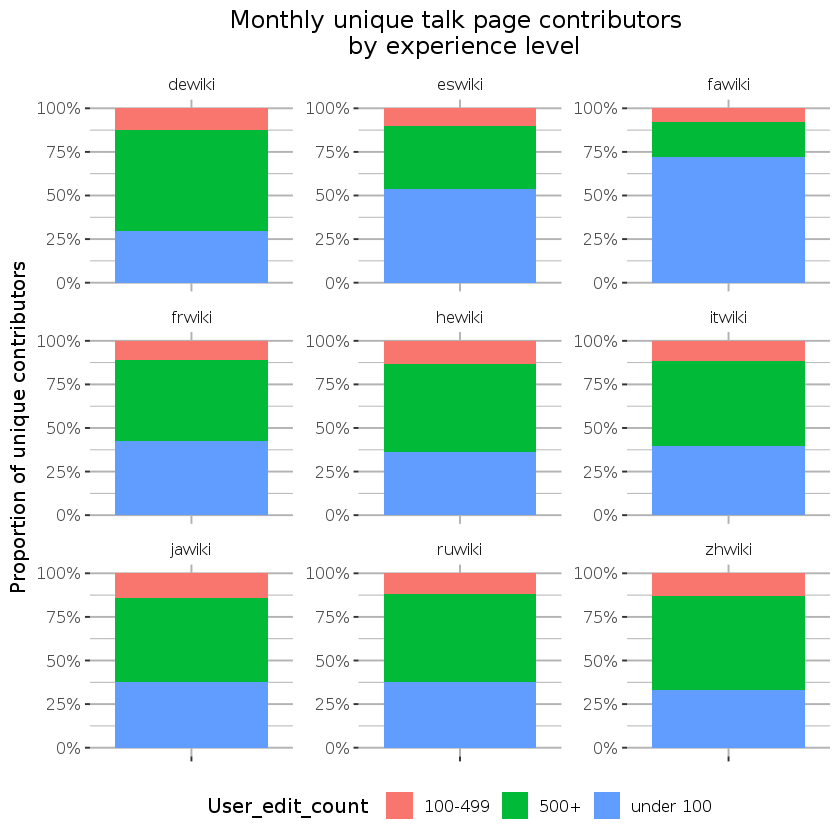

In [144]:
p <- talk_contributors_monthly_bywiki_byeditcount %>%
    filter(wiki %in% c('dewiki', 'frwiki', 'eswiki', 'ruwiki', 'itwiki', 'jawiki', 'fawiki', 'hewiki', 'zhwiki')) %>%
    group_by(wiki, user_edit_count_bucket) %>% 
    summarise(talk_avg_contributors = mean(talk_contributors))%>% 
    ungroup()%>%
    ggplot(aes(x=factor(1), y= talk_avg_contributors, fill = user_edit_count_bucket)) + 
    geom_col(position="fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    facet_wrap(~ wiki, scale = "free_y") +
    labs(title = "Monthly unique talk page contributors \n by experience level",
        fill = "User_edit_count",
        x = NULL,
        y = "Proportion of unique contributors") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

ggsave(filename="talk_contributors_monthly_bywiki_stackedbar.png", plot = p, path = 'Figures')  
p

## Proportion of unique contributors participating on talk pages by Wiki

Defined as the number of unique contributors participating on talk pages divided by the number of contributors participating on any namespace in a month.

In [145]:
#Collect data on the overall number of unique contributors by wiki each month who have made at least 1 edit.

query <- 
"SELECT
  date,
  wiki,
  user_id,
  user_name,
  count(*) as edits, 
  user_is_bot,
  user_edit_count_bucket
FROM
  ( 
  SELECT
    trunc(event_timestamp, 'MONTH') as date,
    wiki_db as wiki,
    event_user_id as user_id,
    event_user_text as user_name,
    page_namespace_historical,
    ARRAY_CONTAINS(event_user_groups_historical, 'bot') as user_is_bot,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count_bucket
FROM wmf.mediawiki_history mwh
inner join canonical_data.wikis_backup_20191030
on
    wiki_db = database_code and
    database_group ==  'wikipedia'
WHERE
    event_timestamp >= '2018-10-01' and 
    event_timestamp < '2019-11-01' and 
    event_entity = 'revision' and
    event_type = 'create' and
    snapshot = '2019-10'  
) as info
GROUP BY
    date,
    wiki,
    user_id,
    user_name,
    user_is_bot,
    user_edit_count_bucket"


In [146]:
all_monthly_contributors <- wmf::query_hive(query)

In [147]:
all_monthly_contributors$date <- as.Date(all_monthly_contributors$date, format = "%Y-%m-%d")

In [ ]:
all_contributors_monthly_bywiki <- all_monthly_contributors %>%
    filter(user_is_bot == 'false',
           user_id != 'NULL') %>%  #remove unregistered users
    group_by(date, wiki) %>%
    summarise(contributors = n_distinct(user_name),
            edits_total = sum(edits))
    
head(all_contributors_monthly_bywiki)


In [ ]:
#Combine the two tables to compare the # of contributors proportion for each wiki

prop_contributors_monthly_bywiki <- 
    merge(all_contributors_monthly_bywiki ,talk_contributors_monthly_bywiki,by= c("date", "wiki")) 

head(prop_contributors_monthly_bywiki)

In [186]:
#Create table of monthly average
prop_contributors_monthly_bywiki_avg <- prop_contributors_monthly_bywiki %>%
     group_by(wiki) %>%
        summarise(talk_contributors_avg = mean(talk_contributors),
                  all_contributors_avg = mean(contributors),
                  prop_talk_contributors = mean(talk_contributors)/ mean(contributors) *100)
    

head(prop_contributors_monthly_bywiki_avg, 10)


wiki,talk_contributors_avg,all_contributors_avg,prop_talk_contributors
<chr>,<dbl>,<dbl>,<dbl>
abwiki,4.538462,15.923077,28.50242
acewiki,4.846154,26.461538,18.31395
adywiki,1.750000,8.750000,20.00000
afwiki,41.230769,170.230769,24.22052
akwiki,2.444444,13.333333,18.33333
alswiki,15.461538,74.384615,20.78594
amwiki,9.000000,40.769231,22.07547
angwiki,4.500000,26.083333,17.25240
anwiki,10.076923,62.000000,16.25310


In [187]:
write.csv(prop_contributors_monthly_bywiki_avg, file = "Data/prop_contributors_monthly_bywiki.csv")

The highest proportion of talk page contributors end up being with very small Wikipedia because they have so few number of contributors on their site. It might be useful to filter these out to find wikis that have both a high number of contributors ande high proportion of talk page editors.

For the purposes of this analysis, I filtered out the wikis with under 1000 contributors. 

In [189]:
prop_contributors_monthly_bywiki_top10 <- prop_contributors_monthly_bywiki_avg %>%
    filter(all_contributors_avg >= 1000) %>%  #Remove wikis with under 1000 contributors. 
    top_n(10, prop_talk_contributors)
 
prop_contributors_monthly_bywiki_top10


wiki,talk_contributors_avg,all_contributors_avg,prop_talk_contributors
<chr>,<dbl>,<dbl>,<dbl>
bnwiki,296.8462,1213.077,24.47051
dewiki,4532.6923,20415.462,22.20225
enwiki,23957.8462,136348.923,17.57098
fawiki,1126.8462,5480.077,20.56260
hewiki,732.2308,3115.462,23.50312
hiwiki,327.0769,1535.923,21.29514
huwiki,331.6154,1832.154,18.09976
plwiki,759.6154,4544.769,16.71406
srwiki,174.4615,1029.462,16.94687


Saving 6.67 x 6.67 in image


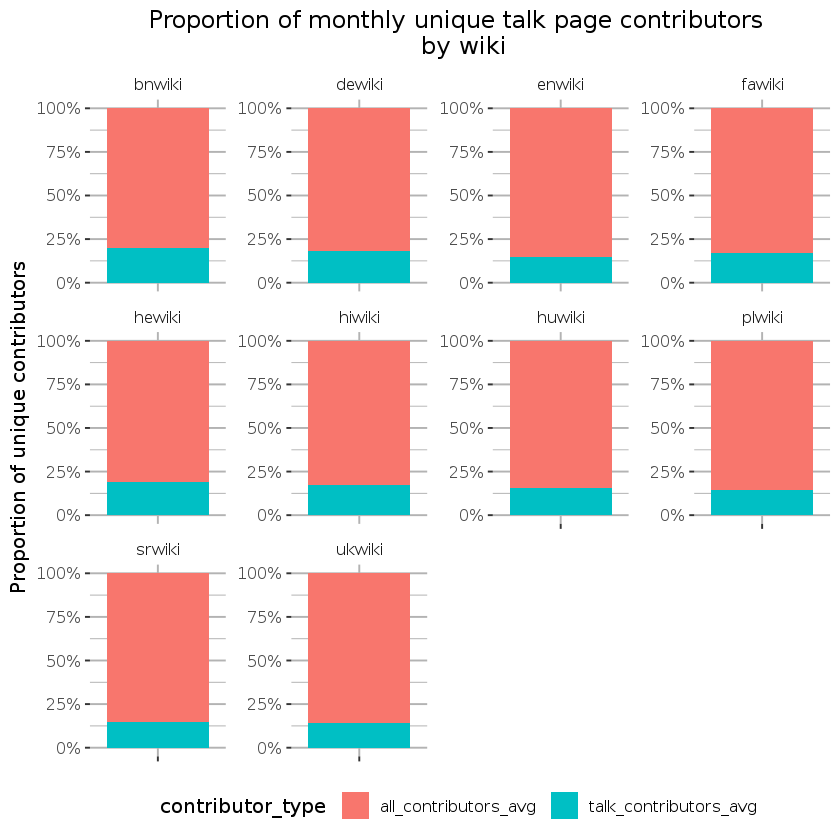

In [190]:
# Plot stacked area chart showing proportion of talk page contributors for the top 10 wikis.
p <- prop_contributors_monthly_bywiki_top10 %>%
    gather("contributor_type","avg_monthly_count", 2:3)  %>%
    ggplot(aes(x=factor(1), y= avg_monthly_count, fill = contributor_type)) + 
    geom_col(position="fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    facet_wrap(~ wiki, scale = "free_y") +
    labs(title = "Proportion of monthly unique talk page contributors \n by wiki",
        fill = "contributor_type",
        x = NULL,
        y = "Proportion of unique contributors") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")
p
ggsave(filename="contributors_prop_bywiki_stackedbar.png", plot = p, path = 'Figures')

Saving 6.67 x 6.67 in image


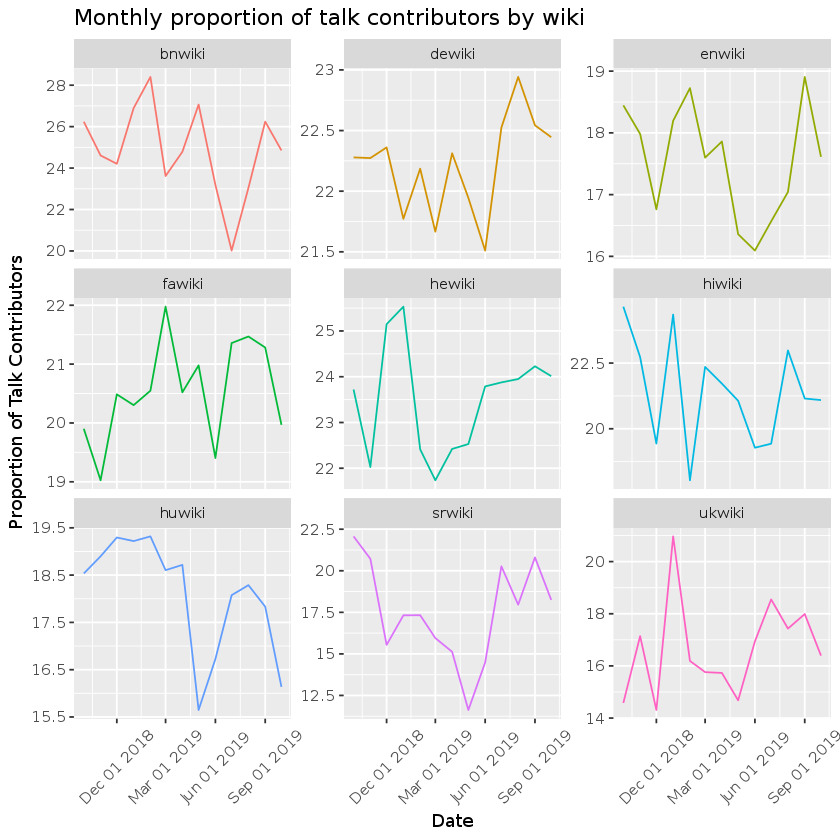

In [191]:
# Plot time series of proportion rates for the the top 10 wikis
# Change to individual stacked bar

prop_contributors_monthly_bywiki_timeseries <- prop_contributors_monthly_bywiki %>%
    select(-c(4, 6)) %>%
    filter(wiki %in% c('bnwiki', 'dewiki', 'enwiki', 'fawiki', 'hewiki', 
                       'hiwiki', 'huwiki', 'plwki', 'srwiki', 'ukwiki')) %>%
    group_by(date, wiki) %>%
    summarise(prop_talk_contributors = talk_contributors/ contributors  *100) %>%
    ggplot(aes(x= date, y= prop_talk_contributors, color = wiki)) +
    geom_line() +
    scale_y_continuous("Proportion of Talk Contributors", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "3 months") +
    facet_wrap(~ wiki, scale = "free_y") +
    labs(title = "Monthly proportion of talk contributors by wiki") +
    theme(legend.position="none",
         axis.text.x = element_text(angle = 45, vjust = 0.5))
    

prop_contributors_monthly_bywiki_timeseries
ggsave(filename="prop_contributors_monthly_bywiki_timeseries.png", plot = prop_contributors_monthly_bywiki_timeseries, path = 'Figures')
